In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.nn.utils as utils
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# set seed
torch.manual_seed(41)
np.random.seed(41)


In [2]:
from typing import Tuple, List, Callable
from torch.distributions import Distribution
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import gaussian_kde
from IPython.display import clear_output
from sklearn.datasets import make_moons

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
# https://sebastiancallh.github.io/post/affine-normalizing-flows/
# uses Real NVP paper

# Define the Normalizing Flow model template
class NormalizingFlow(nn.Module):

    def __init__(self, latent: Distribution, flows: List[nn.Module]):
        super(NormalizingFlow, self).__init__()
        self.latent = latent
        self.flows = nn.ModuleList(flows)

    def latent_log_prob(self, z: torch.Tensor) -> torch.Tensor:
        return self.latent.log_prob(z)

    def latent_sample(self, num_samples: int = 1) -> torch.Tensor:
        return self.latent.sample((num_samples,))

    def sample(self, num_samples: int = 1) -> torch.Tensor:
        '''Sample a new observation x by sampling z from
        the latent distribution and pass through g.'''
        return self.g(self.latent_sample(num_samples))

    def f(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        '''Maps observation x to latent variable z.
        Additionally, computes the log determinant
        of the Jacobian for this transformation.
        Inverse of g.'''
        z, sum_log_abs_det = x, torch.zeros(x.size(0)).to(device) #zeros?
        
        # takes the number of samples and returns a tensor of ones with the same size
        for flow in self.flows:
            z, log_abs_det = flow.f(z)
            sum_log_abs_det += log_abs_det

        return z, sum_log_abs_det

    def g(self, z: torch.Tensor) -> torch.Tensor:
        '''Maps latent variable z to observation x.
        Inverse of f.'''
        with torch.no_grad():
            x = z
            for flow in reversed(self.flows):
                x = flow.g(x)

        return x

    def g_steps(self, z: torch.Tensor) -> List[torch.Tensor]:
        '''Maps latent variable z to observation x
        and stores intermediate results.'''
        xs = [z]
        for flow in reversed(self.flows):
            xs.append(flow.g(xs[-1]))

        return xs

    def log_prob(self, x: torch.Tensor) -> torch.Tensor:
        '''Computes log p(x) using the change of variable formula.'''
        z, log_abs_det = self.f(x)
        return self.latent_log_prob(z) + log_abs_det

    def __len__(self) -> int:
        return len(self.flows)


class AffineCouplingLayer(nn.Module):

    def __init__(self, theta: nn.Module, split: Callable[[torch.Tensor], Tuple[torch.Tensor, torch.Tensor]]):
        super(AffineCouplingLayer, self).__init__()
        self.theta = theta
        self.split = split

    def f(self, x: torch.Tensor) -> torch.Tensor:
        '''f: x -> z. The inverse of g.'''
        x2, x1 = self.split(x)
        t, s = self.theta(x1)
        # Tau coupling function: e^s + t
        z1, z2 = x1, x2 * torch.exp(s) + t
        log_det = s.sum(-1) # sum over the last dimension
        return torch.cat((z1, z2), dim=-1), log_det

    def g(self, z: torch.Tensor) -> torch.Tensor:
        '''g: z -> x. The inverse of f.'''
        z1, z2 = self.split(z)
        t, s = self.theta(z1)
        x1, x2 = z1, (z2 - t) * torch.exp(-s)
        return torch.cat((x2, x1), dim=-1)


# class Conditioner(nn.Module):
#     'The conditioner is the Neural Network that helps fit the model to the data by learning theta_i = (s_i,t_i)'

#     def __init__(self, in_dim: int, out_dim: int, num_hidden: int, hidden_dim: int,num_params: int):
#         super(Conditioner, self).__init__()
#         self.input = nn.Linear(in_dim, hidden_dim)

#         self.hidden = nn.ModuleList([
#             nn.Linear(hidden_dim, hidden_dim)
#             for _ in range(num_hidden)
#         ])
        
#         self.num_params = num_params
#         self.out_dim = out_dim
#         self.dims = nn.Linear(hidden_dim, out_dim * num_params)

#         # Apply Xavier initialization to linear layers
#         # for layer in self.hidden:
#         #     if isinstance(layer, nn.Linear):
#         #         nn.init.xavier_uniform_(layer.weight)
#         #         nn.init.constant_(layer.bias, 0.001)

#         # # Apply Xavier initialization to dims (output) layer
#         # nn.init.xavier_uniform_(self.dims.weight)
#         # nn.init.constant_(self.dims.bias, 0.001)

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         x = F.leaky_relu(self.input(x))
#         for h in self.hidden:
#             x = F.leaky_relu(h(x))

#         batch_params = self.dims(x).reshape(x.size(0), self.out_dim, -1)
#         batch_params[:,:,1] *= 0.001
#         batch_params[:,:,0] *= 0.001
#         params = batch_params.chunk(self.num_params, dim=-1)
#         return [p.squeeze(-1) for p in params]

class Conditioner(nn.Module):
    'The conditioner is the Neural Network that helps fit the model to the data by learning theta_i = (s_i,t_i)'

    def __init__(self, in_dim: int, out_dim: int, num_hidden: int, hidden_dim: int, num_params: int):
        super(Conditioner, self).__init__()
        self.input = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            #nn.BatchNorm1d(hidden_dim),  # Add BatchNorm layer
            nn.LeakyReLU(inplace=True)  # Add ReLU activation
        )
        self.hidden = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                #nn.BatchNorm1d(hidden_dim),  # Add BatchNorm layer
                nn.LeakyReLU(inplace=True)  # Add ReLU activation
            )
            for _ in range(num_hidden)
        ])

        self.num_params = num_params
        self.out_dim = out_dim
        self.dims = nn.Linear(hidden_dim, out_dim * num_params)
        # self.dims = nn.Sequential(
        #     nn.Linear(hidden_dim, out_dim * num_params),
        #     nn.BatchNorm1d(out_dim * num_params),  # Add BatchNorm layer
        #     nn.Tanh()  # You can use Tanh or another appropriate activation here
        # )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.input(x)
        for h in self.hidden:
            x = h(x)

        batch_params = self.dims(x).reshape(x.size(0), self.out_dim, -1)
        batch_params[:,:,1] *= 0.001
        batch_params[:,:,0] *= 0.001
        params = batch_params.chunk(self.num_params, dim=-1)
        return [p.squeeze(-1) for p in params]


def init_weights(model):
    if isinstance(model, nn.Linear):
        nn.init.xavier_normal_(model.weight) # under initialisering på output lag gange med 1e-3 - som alternativ på batch_params[:,:,1] *= 0.001
        nn.init.zeros_(model.bias)

def train_flow_model(flow_model, optimiser, X_train, num_epochs, class_label):
    losses = []
    #losses = torch.zeros(num_epochs)
    scheduler = optim.lr_scheduler.StepLR(optimiser, step_size=1000, gamma=0.999)
    for epoch in range(num_epochs):
        optimiser.zero_grad()
        log_prob = flow_model.log_prob(X_train)
        loss = -torch.mean(log_prob)
        loss.backward()
        utils.clip_grad_norm_(flow_model.parameters(), max_norm=5.0)  # Adjust max_norm as needed
        optimiser.step()
        scheduler.step()
        #losses[epoch] = loss.item()
        losses.append(loss.item())

        if (epoch + 1) % 100 == 0:
            print(f'Flow model {class_label} Epoch [{epoch + 1}/{num_epochs}], Loss: {loss:.4f}')
    return losses, flow_model   

class label 0
Flow model 0 Epoch [100/25000], Loss: 23.1323
Flow model 0 Epoch [200/25000], Loss: 9.7552
Flow model 0 Epoch [300/25000], Loss: 6.3321
Flow model 0 Epoch [400/25000], Loss: 5.6749
Flow model 0 Epoch [500/25000], Loss: 4.4810
Flow model 0 Epoch [600/25000], Loss: 2.3553
Flow model 0 Epoch [700/25000], Loss: 2.2305
Flow model 0 Epoch [800/25000], Loss: 2.1735
Flow model 0 Epoch [900/25000], Loss: 2.1325
Flow model 0 Epoch [1000/25000], Loss: 1.9392
Flow model 0 Epoch [1100/25000], Loss: 1.8124
Flow model 0 Epoch [1200/25000], Loss: 1.6853
Flow model 0 Epoch [1300/25000], Loss: 1.7450
Flow model 0 Epoch [1400/25000], Loss: 1.5020
Flow model 0 Epoch [1500/25000], Loss: 1.4452
Flow model 0 Epoch [1600/25000], Loss: 1.7134
Flow model 0 Epoch [1700/25000], Loss: 1.7999
Flow model 0 Epoch [1800/25000], Loss: 1.4887
Flow model 0 Epoch [1900/25000], Loss: 1.3638
Flow model 0 Epoch [2000/25000], Loss: 1.3546
Flow model 0 Epoch [2100/25000], Loss: 1.3751
Flow model 0 Epoch [2200/250

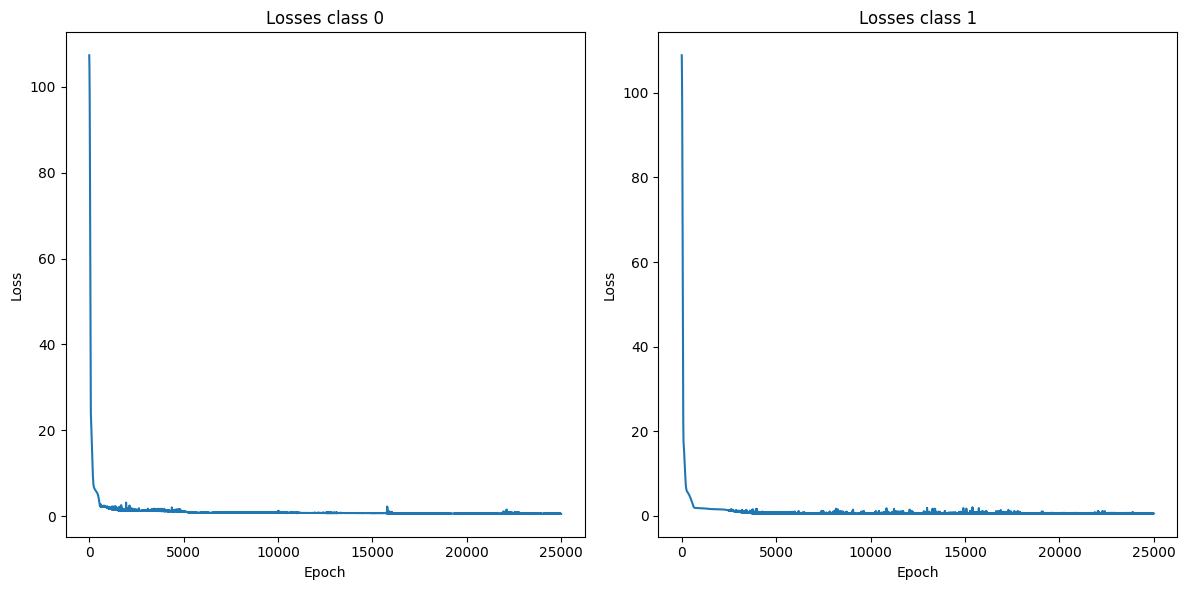

In [16]:
num_classes = 2
num_samples_per_class = 500
noise = 0.1
X_train, y_train = make_moons(n_samples=num_classes*num_samples_per_class, noise=noise)
X_train = torch.FloatTensor(np.array(X_train))
y_train = np.array(y_train)
# Split the data into two classes
class0 = X_train[y_train == 0]
class1 = X_train[y_train == 1]
#concatenate the two classes
X_train = torch.stack((class0, class1))
X_train = X_train.to(device)
X_train += 10
## WHY DOES IT WORK SO NICELY WITH +10??
# Because the normalising flows distance measure

data_dim = X_train.shape[-1] # equal 2, as is the last dimension of X_train
in_dim= 1 # data_dim // 2 # since we split the data
out_dim= 1 # data_dim // 2
num_params = 2 # s and t
num_hidden = 2 # number of hidden layers
hidden_dim = 32 # neurons in hidden layers
num_flows = 4 # number of coupling flow layers
lr = 0.0030
weight_decay = 9e-6  # L2 regularization strength to prevent overfitting in AdamW 
num_epochs = 25000  # flere epochs

#conditioner = Conditioner(in_dim=in_dim, out_dim=out_dim, num_hidden=num_hidden, hidden_dim=hidden_dim, num_params=num_params)
# affine_coupling = AffineCouplingLayer(conditioner, split=lambda x: x.chunk(2, dim=-1)) # split the tensor into 2 parts
# flows = [affine_coupling for _ in range(num_flows)]

# latent_distribution = torch.distributions.MultivariateNormal(loc=torch.zeros(data_dim).to(device), scale_tril=torch.eye(data_dim).to(device))

flow_models = []
optimisers = []
for class_label in range(num_classes):
    conditioner = Conditioner(in_dim=in_dim, out_dim=out_dim, num_hidden=num_hidden, hidden_dim=hidden_dim, num_params=num_params)
    affine_coupling = AffineCouplingLayer(conditioner, split=lambda x: x.chunk(2, dim=-1)) # split the tensor into 2 parts
    flows = [affine_coupling for _ in range(num_flows)]
    latent_distribution = torch.distributions.MultivariateNormal(loc=torch.zeros(data_dim).to(device), scale_tril=torch.eye(data_dim).to(device))

    flow_model = NormalizingFlow(latent_distribution, flows).to(device)
    #flow_model = NormalizingFlow(latent_distribution, flows).apply(init_weights).to(device)
    optimiser = torch.optim.Adam(flow_model.parameters(), lr=lr, weight_decay=weight_decay)
    #optimiser = torch.optim.AdamW(flow_model.parameters(), lr=lr, weight_decay=weight_decay)
    flow_models.append(flow_model)
    optimisers.append(optimiser)

all_losses = []
flow_models_trained = []
for class_label in range(num_classes):
    print("class label",class_label)
    flow_models[class_label].apply(init_weights)
    losses, flow_model = train_flow_model(flow_models[class_label], optimisers[class_label], X_train[class_label], num_epochs, class_label)
    all_losses.append(losses)
    flow_models_trained.append(flow_model)
all_losses = np.array(all_losses)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(all_losses[0,10:])
axes[0].set_title("Losses class 0")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[1].plot(all_losses[1,10:])
axes[1].set_title("Losses class 1")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
plt.tight_layout()
plt.show()

X_train = X_train.cpu().numpy()
print("Final loss class 0: ", all_losses[0,-1])
print("Final loss class 1: ", all_losses[1,-1])

In [23]:
print("Final loss class 0: ", all_losses[0,-1])
print("Final loss class 1: ", all_losses[1,-1])

Final loss class 0:  0.6115878224372864
Final loss class 1:  0.49690642952919006


In [18]:
# Generate samples from the trained models
num_samples_gen_per_class = 500
generated_samples = []
with torch.no_grad():
    for class_label in range(num_classes):
        samples = flow_models[class_label].sample(num_samples=num_samples_gen_per_class).cpu().numpy()
        generated_samples.append(samples)
generated_samples = np.array(generated_samples)
print("Generated samples shape: ", generated_samples.shape)

Generated samples shape:  (2, 500, 2)


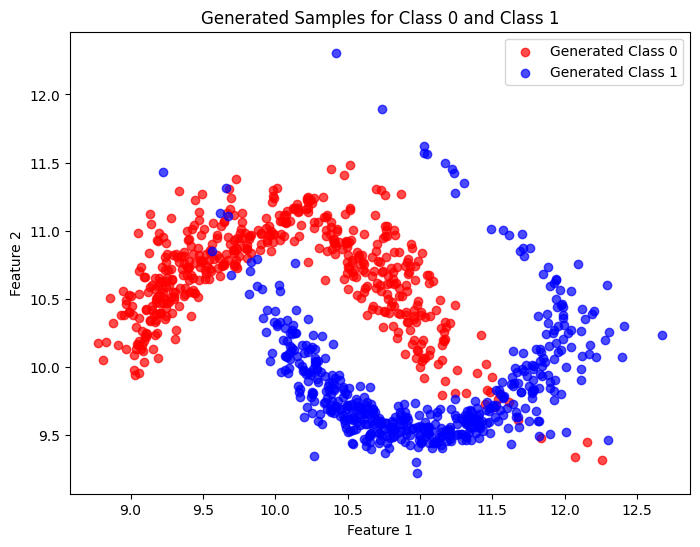

In [19]:
# Check if class 0 from generated samples is different from class 1 in generated samples
colors = ['r', 'b']
plt.figure(figsize=(8, 6))
for class_label in range(num_classes):
    plt.scatter(generated_samples[class_label][:, 0], generated_samples[class_label][:, 1], 
                color=colors[class_label], alpha = 0.7, label=f'Generated Class {class_label}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.title('Generated Samples for Class 0 and Class 1')
plt.show()

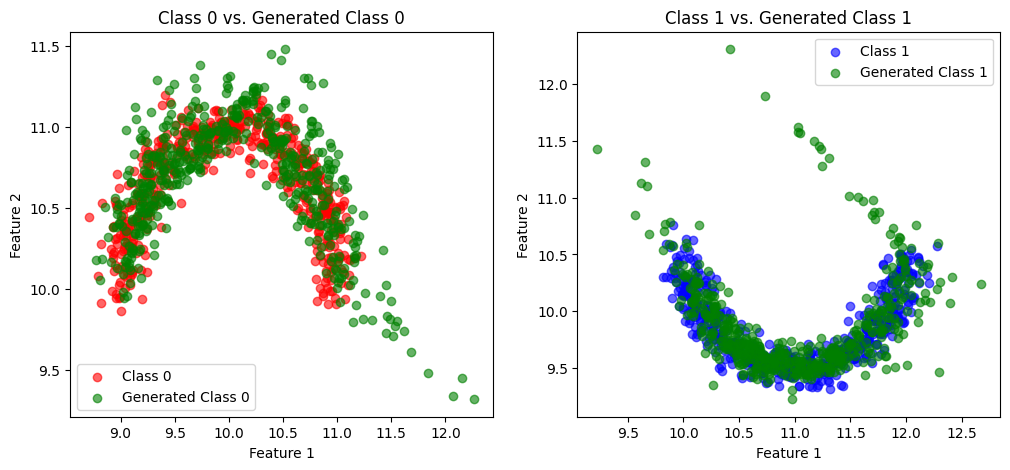

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Plot Class 0
axes[0].scatter(X_train[0, :, 0], X_train[0, :, 1], color='r', alpha=0.6, label='Class 0')
axes[0].scatter(generated_samples[0, :, 0], generated_samples[0, :, 1], color='g', alpha=0.6, label='Generated Class 0')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')
axes[0].set_title('Class 0 vs. Generated Class 0')
axes[0].legend()

# Plot Class 1
axes[1].scatter(X_train[1, :, 0], X_train[1, :, 1], color='b', alpha=0.6, label='Class 1')
axes[1].scatter(generated_samples[1, :, 0], generated_samples[1, :, 1], color='g', alpha=0.6, label='Generated Class 1')
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')
axes[1].set_title('Class 1 vs. Generated Class 1')
axes[1].legend()
plt.show()

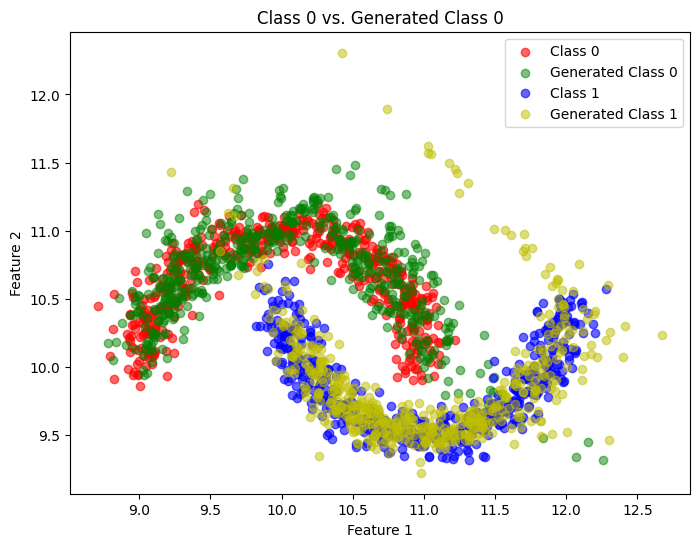

In [21]:
plt.figure(figsize=(8, 6))
plt.scatter(X_train[0, :, 0],X_train[0, :, 1], color='r', alpha=0.6, label='Class 0')
plt.scatter(generated_samples[0, :, 0], generated_samples[0, :, 1], color='g', alpha=0.5, label='Generated Class 0')
plt.scatter(X_train[1, :, 0], X_train[1, :, 1], color='b', alpha=0.6, label='Class 1')
plt.scatter(generated_samples[1, :, 0], generated_samples[1, :, 1], color='y', alpha=0.5, label='Generated Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Classes vs. Generated Classes')
plt.legend()

In [25]:
nx, ny = (100, 100)
x = np.linspace(-4, 4, nx)
y = np.linspace(-4, 4, ny)
xv, yv = np.meshgrid(x, y)
mesh = np.stack((xv.flatten(), yv.flatten()),axis=1)
mesh_tensor = torch.FloatTensor(mesh).to(device)
print(mesh_tensor.shape)

# class 0
logprobs = flow_models_trained[0].log_prob(mesh_tensor).clamp(min=-10, max=10)
logprobs = logprobs.cpu().reshape((100,100)).detach().numpy()
# class 1
logprobs2 = flow_models_trained[1].log_prob(mesh_tensor).clamp(min=-10, max=10)
logprobs2 = logprobs2.cpu().reshape((100,100)).detach().numpy()


# Plot the log probability as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(np.exp(logprobs), extent=[-4,4,-4,4], origin='lower', cmap='viridis')
plt.scatter(X_train[0, :, 0], X_train[0, :, 1], label='Original Data', alpha=0.07, color='red')
plt.colorbar(label='Probability Density')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Probability Density Function')
plt.show()


plt.figure(figsize=(8, 6))
plt.imshow(np.exp(logprobs2), extent=[-4,4,-4,4], origin='lower', cmap='viridis')
plt.scatter(X_train[1, :, 0], X_train[1, :, 1], label='Original Data', alpha=0.07, color='red')
plt.colorbar(label='Probability Density')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Probability Density Function')
plt.show()

#logprobs = flow_models[class_label].log_prob(X_tensor2)

# logprobs = logprobs.reshape((100,100))
#logprobs = logprobs.cpu().reshape((100,100)).detach().numpy()
# plt.figure(figsize = (8,8))
# plt.imshow(np.exp(logprobs), origin='lower', extent=[5,15,5,15])

# class_label = 1
# with torch.no_grad():
#     samples_c1 = flow_models[class_label].sample(num_samples=num_samples_gen_per_class).cpu().numpy()

# #plt.scatter(synthetic_data[:, 0],synthetic_data[:, 1], label='Generated Samples', alpha=0.05, color='yellow')
# plt.scatter(X_train[:, 0], X_train[:, 1], label='Original Data', alpha=0.07, color='red')
# plt.legend()
# plt.show()

torch.Size([10000, 2])


IndexError: list index out of range

In [ ]:
#scaler = StandardScaler()
#X_train = torch.stack([torch.FloatTensor(scaler.fit_transform(X_class)) for X_class in X_train])

# Data load
num_classes = 2
num_samples_per_class = 500
noise = 0.05
X_train, y_train = make_moons(n_samples=num_classes*num_samples_per_class, noise=noise)
X_train = torch.FloatTensor(np.array(X_train))
y_train = np.array(y_train)
# Multi class standardisation 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

#Plot the standardised dataset
# Plot the dataset
plt.figure(figsize=(5, 5))
colors = ['r', 'b']
for class_label in range(num_classes):
    plt.scatter(X_train[y_train == class_label][:, 0], 
                X_train[y_train == class_label][:, 1],
                color=colors[class_label], marker='o', label=f'Class {class_label}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.title('Two Moons Dataset (Class 0 and Class 1)')
plt.show()

# class0 = X_train[y_train == 0]
# class1 = X_train[y_train == 1]
# X_train = torch.stack((class0, class1))
# print("X_train shape: ", X_train.shape)

## Test #2 

class label 0
Flow model 0 Epoch [100/50000], Loss: 21.0889
Flow model 0 Epoch [200/50000], Loss: 9.0738
Flow model 0 Epoch [300/50000], Loss: 6.4995
Flow model 0 Epoch [400/50000], Loss: 5.8281
Flow model 0 Epoch [500/50000], Loss: 5.2533
Flow model 0 Epoch [600/50000], Loss: 4.5974
Flow model 0 Epoch [700/50000], Loss: 3.4891
Flow model 0 Epoch [800/50000], Loss: 2.0037
Flow model 0 Epoch [900/50000], Loss: 1.4035
Flow model 0 Epoch [1000/50000], Loss: 1.2218
Flow model 0 Epoch [1100/50000], Loss: 1.1697
Flow model 0 Epoch [1200/50000], Loss: 1.1174
Flow model 0 Epoch [1300/50000], Loss: 1.0571
Flow model 0 Epoch [1400/50000], Loss: 1.0204
Flow model 0 Epoch [1500/50000], Loss: 1.0041
Flow model 0 Epoch [1600/50000], Loss: 0.9465
Flow model 0 Epoch [1700/50000], Loss: 0.9946
Flow model 0 Epoch [1800/50000], Loss: 0.8456
Flow model 0 Epoch [1900/50000], Loss: 0.8416
Flow model 0 Epoch [2000/50000], Loss: 0.8020
Flow model 0 Epoch [2100/50000], Loss: 0.7697
Flow model 0 Epoch [2200/500

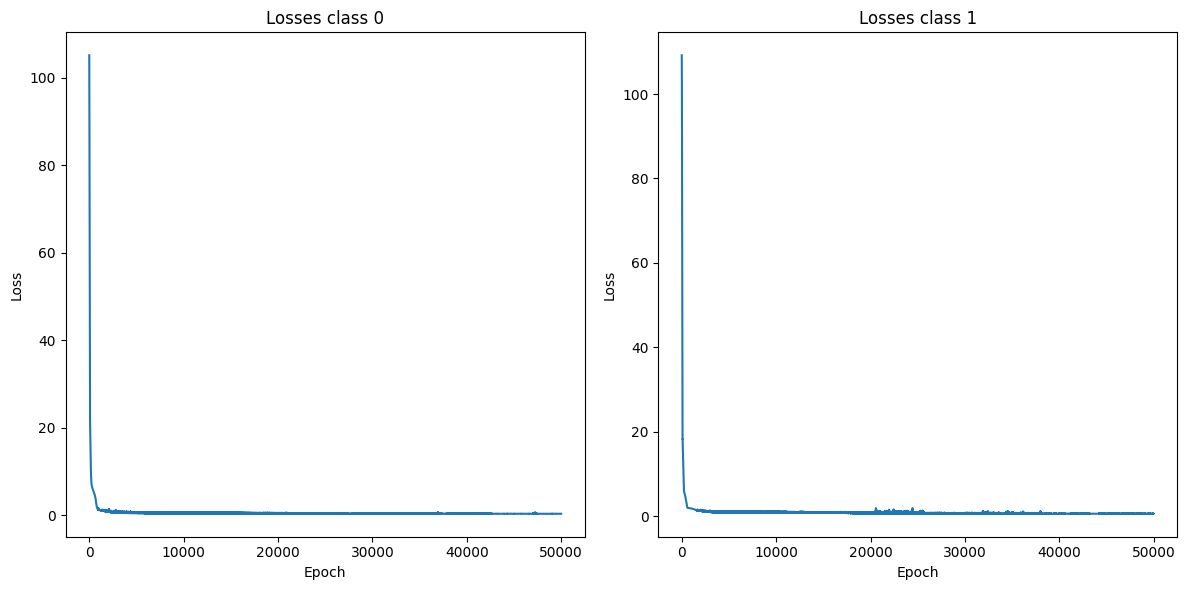

Final loss class 0:  0.3125773072242737
Final loss class 1:  0.5538161993026733


In [26]:
num_classes = 2
num_samples_per_class = 500
noise = 0.1
X_train, y_train = make_moons(n_samples=num_classes*num_samples_per_class, noise=noise)
X_train = torch.FloatTensor(np.array(X_train))
y_train = np.array(y_train)
# Split the data into two classes
class0 = X_train[y_train == 0]
class1 = X_train[y_train == 1]
#concatenate the two classes
X_train = torch.stack((class0, class1))
X_train = X_train.to(device)
X_train += 10
## WHY DOES IT WORK SO NICELY WITH +10??
# Because the normalising flows distance measure

data_dim = X_train.shape[-1] # equal 2, as is the last dimension of X_train
in_dim= 1 # data_dim // 2 # since we split the data
out_dim= 1 # data_dim // 2
num_params = 2 # s and t
num_hidden = 2 # number of hidden layers
hidden_dim = 32 # neurons in hidden layers
num_flows = 4 # number of coupling flow layers
lr = 0.0030
weight_decay = 9e-6  # L2 regularization strength to prevent overfitting in AdamW 
num_epochs = 50000  # flere epochs

#conditioner = Conditioner(in_dim=in_dim, out_dim=out_dim, num_hidden=num_hidden, hidden_dim=hidden_dim, num_params=num_params)
# affine_coupling = AffineCouplingLayer(conditioner, split=lambda x: x.chunk(2, dim=-1)) # split the tensor into 2 parts
# flows = [affine_coupling for _ in range(num_flows)]

# latent_distribution = torch.distributions.MultivariateNormal(loc=torch.zeros(data_dim).to(device), scale_tril=torch.eye(data_dim).to(device))

flow_models = []
optimisers = []
for class_label in range(num_classes):
    conditioner = Conditioner(in_dim=in_dim, out_dim=out_dim, num_hidden=num_hidden, hidden_dim=hidden_dim, num_params=num_params)
    affine_coupling = AffineCouplingLayer(conditioner, split=lambda x: x.chunk(2, dim=-1)) # split the tensor into 2 parts
    flows = [affine_coupling for _ in range(num_flows)]
    latent_distribution = torch.distributions.MultivariateNormal(loc=torch.zeros(data_dim).to(device), scale_tril=torch.eye(data_dim).to(device))

    flow_model = NormalizingFlow(latent_distribution, flows).to(device)
    #flow_model = NormalizingFlow(latent_distribution, flows).apply(init_weights).to(device)
    optimiser = torch.optim.Adam(flow_model.parameters(), lr=lr, weight_decay=weight_decay)
    #optimiser = torch.optim.AdamW(flow_model.parameters(), lr=lr, weight_decay=weight_decay)
    flow_models.append(flow_model)
    optimisers.append(optimiser)

all_losses = []
flow_models_trained = []
for class_label in range(num_classes):
    print("class label",class_label)
    flow_models[class_label].apply(init_weights)
    losses, flow_model = train_flow_model(flow_models[class_label], optimisers[class_label], X_train[class_label], num_epochs, class_label)
    all_losses.append(losses)
    flow_models_trained.append(flow_model)
all_losses = np.array(all_losses)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(all_losses[0,100:])
axes[0].set_title("Losses class 0")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[1].plot(all_losses[1,100:])
axes[1].set_title("Losses class 1")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
plt.tight_layout()
plt.show()

X_train = X_train.cpu().numpy()
print("Final loss class 0: ", all_losses[0,-1])
print("Final loss class 1: ", all_losses[1,-1])

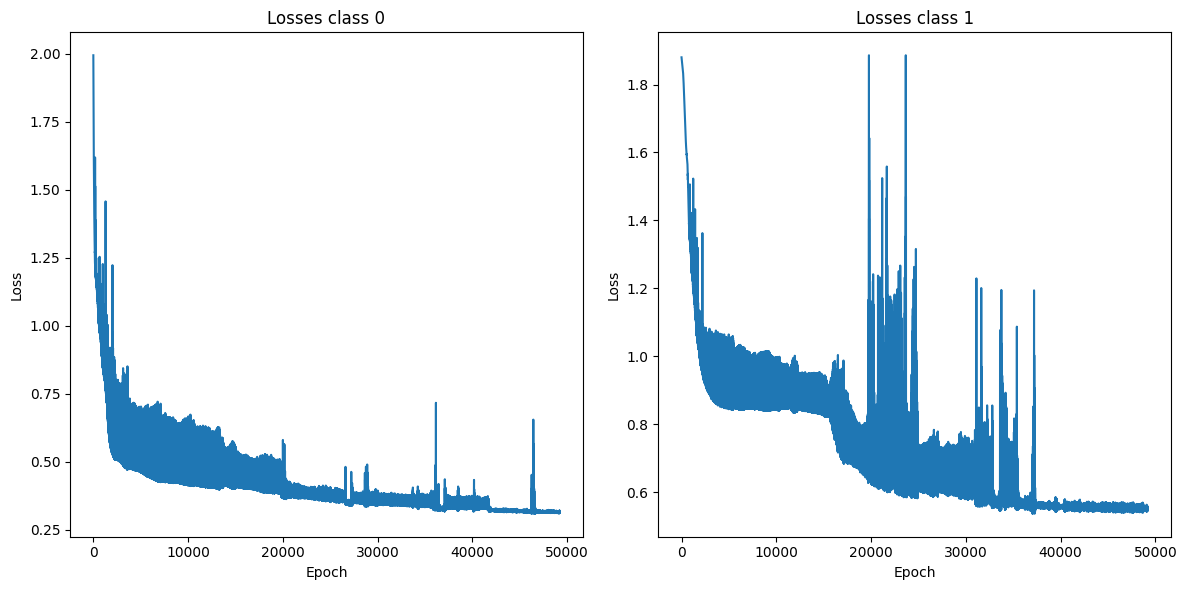

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(all_losses[0,800:])
axes[0].set_title("Losses class 0")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[1].plot(all_losses[1,800:])
axes[1].set_title("Losses class 1")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
plt.tight_layout()
plt.show()

In [40]:
# Generate samples from the trained models
num_samples_gen_per_class = 500
generated_samples = []
with torch.no_grad():
    for class_label in range(num_classes):
        samples = flow_models[class_label].sample(num_samples=num_samples_gen_per_class).cpu().numpy()
        generated_samples.append(samples)
generated_samples = np.array(generated_samples)
print("Generated samples shape: ", generated_samples.shape)

Generated samples shape:  (2, 500, 2)


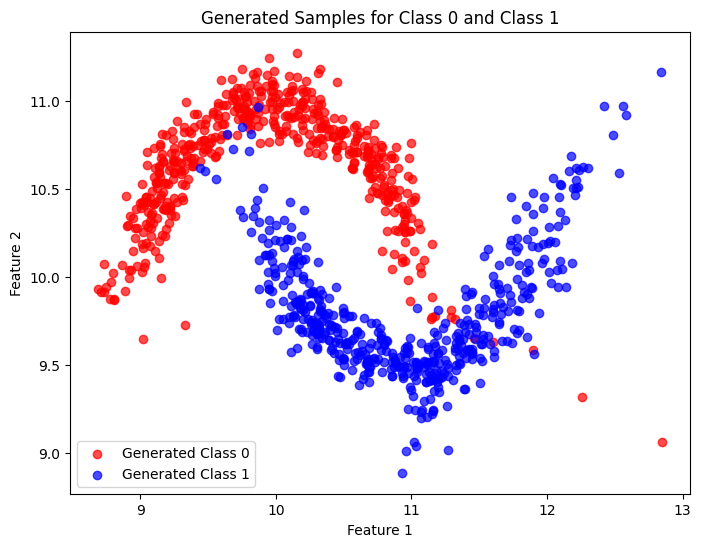

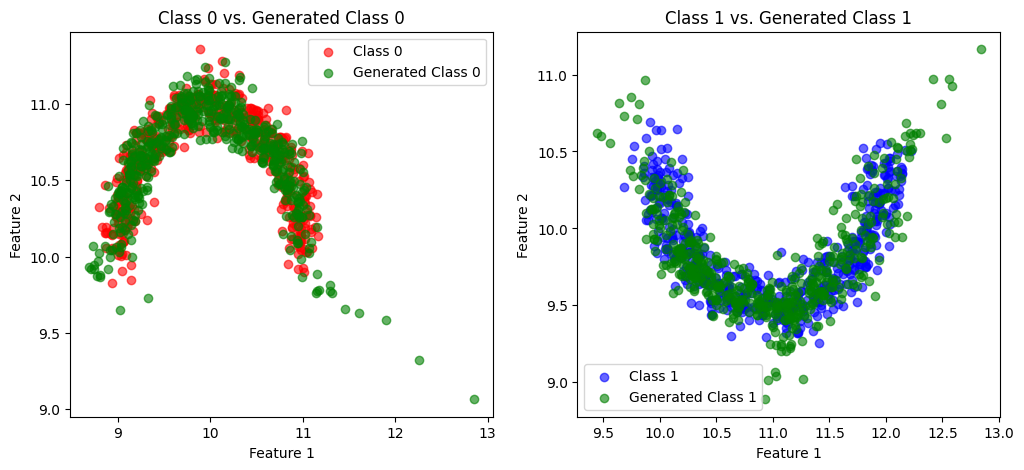

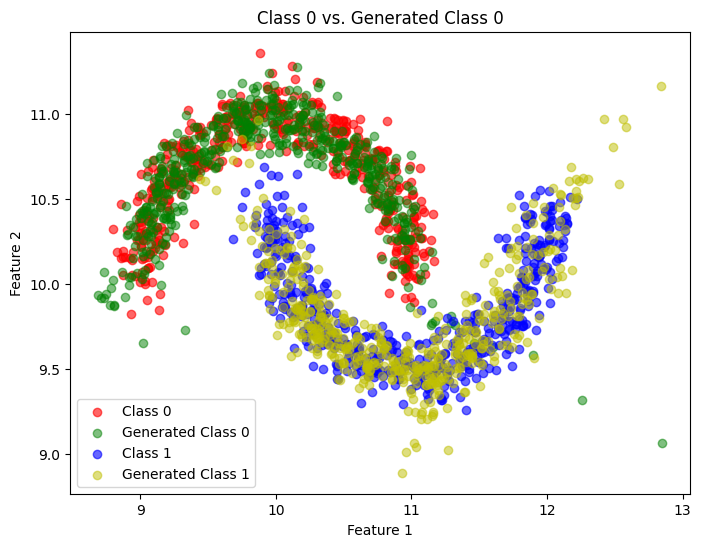

In [43]:
# Check if class 0 from generated samples is different from class 1 in generated samples
colors = ['r', 'b']
plt.figure(figsize=(8, 6))
for class_label in range(num_classes):
    plt.scatter(generated_samples[class_label][:, 0], generated_samples[class_label][:, 1], 
                color=colors[class_label], alpha = 0.7, label=f'Generated Class {class_label}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.title('Generated Samples for Class 0 and Class 1')
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Plot Class 0
axes[0].scatter(X_train[0, :, 0], X_train[0, :, 1], color='r', alpha=0.6, label='Class 0')
axes[0].scatter(generated_samples[0, :, 0], generated_samples[0, :, 1], color='g', alpha=0.6, label='Generated Class 0')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')
axes[0].set_title('Class 0 vs. Generated Class 0')
axes[0].legend()

# Plot Class 1
axes[1].scatter(X_train[1, :, 0], X_train[1, :, 1], color='b', alpha=0.6, label='Class 1')
axes[1].scatter(generated_samples[1, :, 0], generated_samples[1, :, 1], color='g', alpha=0.6, label='Generated Class 1')
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')
axes[1].set_title('Class 1 vs. Generated Class 1')
axes[1].legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(X_train[0, :, 0],X_train[0, :, 1], color='r', alpha=0.6, label='Class 0')
plt.scatter(generated_samples[0, :, 0], generated_samples[0, :, 1], color='g', alpha=0.5, label='Generated Class 0')
plt.scatter(X_train[1, :, 0], X_train[1, :, 1], color='b', alpha=0.6, label='Class 1')
plt.scatter(generated_samples[1, :, 0], generated_samples[1, :, 1], color='y', alpha=0.5, label='Generated Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Class 0 vs. Generated Class 0')
plt.legend()

torch.Size([10000, 2])


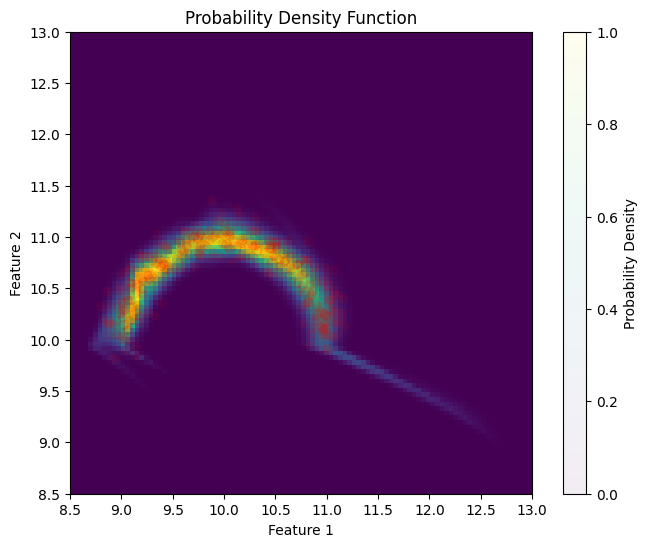

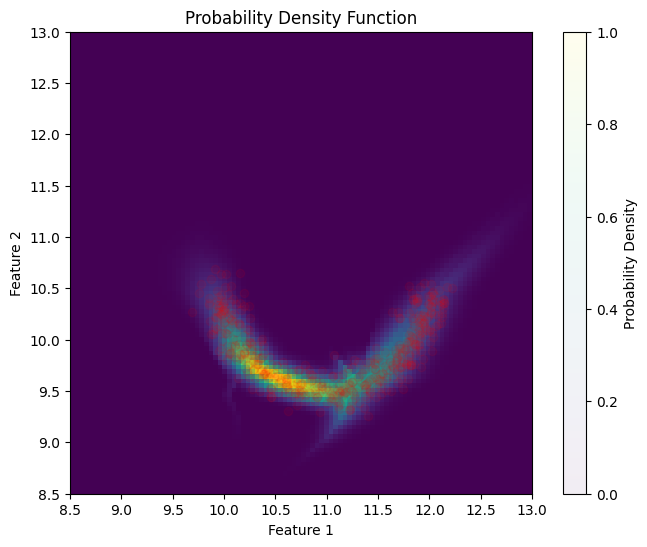

In [44]:
nx, ny = (100, 100)
x = np.linspace(8.5, 13, nx)
y = np.linspace(8.5, 13, ny)
xv, yv = np.meshgrid(x, y)
mesh = np.stack((xv.flatten(), yv.flatten()),axis=1)
mesh_tensor = torch.FloatTensor(mesh).to(device)
print(mesh_tensor.shape)

# class 0
logprobs = flow_models_trained[0].log_prob(mesh_tensor).clamp(min=-10, max=10)
logprobs = logprobs.cpu().reshape((100,100)).detach().numpy()
# class 1
logprobs2 = flow_models_trained[1].log_prob(mesh_tensor).clamp(min=-10, max=10)
logprobs2 = logprobs2.cpu().reshape((100,100)).detach().numpy()


# Plot the log probability as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(np.exp(logprobs), extent=[8.5,13,8.5,13], origin='lower', cmap='viridis')
plt.scatter(X_train[0, :, 0], X_train[0, :, 1], label='Original Data', alpha=0.07, color='red')
plt.colorbar(label='Probability Density')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Probability Density Function')
plt.show()


plt.figure(figsize=(8, 6))
plt.imshow(np.exp(logprobs2), extent=[8.5,13,8.5,13], origin='lower', cmap='viridis')
plt.scatter(X_train[1, :, 0], X_train[1, :, 1], label='Original Data', alpha=0.07, color='red')
plt.colorbar(label='Probability Density')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Probability Density Function')
plt.show()